In [2]:
import polara
from scipy.sparse import csr_matrix, diags, identity
import numpy as np

In [3]:
data_ , genres_info = polara.get_movielens_data(
    get_genres=True, # get genre information in addition to ratings
    split_genres=False,
    include_time=True
)

In [4]:
data_.movieid.nunique()

3706

In [5]:
genres_info['genres'] = genres_info['genres'].apply(lambda x: x.split('|'))


In [6]:
all_genres = set(genres_info['genres'].sum())

In [7]:
for genre in all_genres:
    genres_info[genre] = genres_info['genres'].apply(lambda x: genre in x).astype(int)

In [8]:
genres_info

,movieid,movienm,genres,Children's,Mystery,Sci-Fi,War,Film-Noir,Western,Fantasy,...,Thriller,Drama,Adventure,Romance,Crime,Comedy,Action,Horror,Musical,Animation
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3879,3949,Requiem for a Dream (2000),[Drama],0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),[Drama],0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),[Drama],0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
item_feature_mtx = genres_info.iloc[:,3:]
item_feature_mtx.shape

(3883, 18)

In [10]:
item_feature_mtx = csr_matrix(item_feature_mtx.T)

In [11]:
from dataprep import generate_interactions_matrix

In [12]:
def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the warm-start evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns userid, movieid, and timestamp.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the timestamp column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        training is a subset of data used for training the recommender system.
        testset is a subset of data used for generating recommendations for the test users.
        holdout is a subset excluded from testset containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input data into three subsets: training, testset, and holdout.
    The split is performed based on the timestamp column of data, using time_split_q as the quantile value.
    The holdout dataset contains only the immediate interactions following the fixed timepoint for each test user from the testset.
    The set of users in training is disjoint with the set of users in the testset, which implements the warm-start scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['movieid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('movieid not in @holdout_.movieid')
    train_users = training.userid.unique()
    testset_ = rest_.query('movieid in @holdout_.movieid and userid in @train_users')
    test_items = testset_.movieid.unique()
    holdout = holdout_.query(
        # if user is not in test_users then no evluation is possible,
        # if item is not in train_users it's cold start -> must be excluded
        'movieid in @test_items and userid in @train_users'
        # 'userid in @test_users and movieid in @train_items'
    ).sort_values('movieid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'movieid in @holdout.movieid'
    ).sort_values('movieid')
    return training, testset, holdout

In [13]:
data_ = data_.query('userid not in [3391, 5950, 5329, 5654, 5484]')

In [14]:
training_ , testset_ , holdout = timepoint_split(data_, time_split_q=0.9996)

In [15]:
training_.shape, testset_ .shape, holdout.shape

((790825, 4), (206411, 4), (337, 4))

In [16]:
holdout.userid.value_counts()

4958    61
736     37
419     23
4697    14
195     14
        ..
937      1
3562     1
1958     1
1063     1
4312     1
Name: userid, Length: 66, dtype: int64

In [17]:
from dataprep import transform_indices, reindex_data
training , data_index = transform_indices(training_ , 'userid', 'movieid')
# train = reindex_data(train_, data_index)
# testset_ = testset.query('movieid in @cold_items')
testset = reindex_data(testset_, data_index, fields='users')
testset = testset.query('userid >= 0')

In [18]:
training.shape, testset.shape, holdout.shape

((790825, 4), (206411, 4), (337, 4))

In [19]:
genres = reindex_data(genres_info, data_index, fields='items')

In [20]:
genres = genres.query('movieid >= 0').sort_values(by='movieid')
genres

,movieid,movienm,genres,Children's,Mystery,Sci-Fi,War,Film-Noir,Western,Fantasy,...,Thriller,Drama,Adventure,Romance,Crime,Comedy,Action,Horror,Musical,Animation
2,0,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,Waiting to Exhale (1995),"[Comedy, Drama]",0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,2,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,3,Sabrina (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
7,4,Tom and Huck (1995),"[Adventure, Children's]",1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,3363,Get Carter (1971),[Thriller],0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3879,3364,Requiem for a Dream (2000),[Drama],0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3880,3365,Tigerland (2000),[Drama],0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3881,3366,Two Family House (2000),[Drama],0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [21]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
    user_index = data_index['users'],
    item_index = data_index['items']
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 6035,
 'n_items': 3368,
 'user_index': Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
             ...
             6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
            dtype='int64', name='userid', length=6035),
 'item_index': Int64Index([   3,    4,    5,    7,    8,    9,   10,   11,   13,   14,
             ...
             3942, 3943, 3944, 3945, 3946, 3947, 3949, 3950, 3951, 3952],
            dtype='int64', name='movieid', length=3368)}

In [22]:
user_item_mtx = generate_interactions_matrix(training, data_description)
user_item_mtx

<3368x6035 sparse matrix of type '<class 'numpy.int64'>'
	with 790825 stored elements in Compressed Sparse Column format>

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity_zd(matrix):
    '''Build cosine similarity matrix with zero diagonal.'''
    similarity = cosine_similarity(matrix, dense_output=False)
    similarity.setdiag(0)
    similarity.eliminate_zeros()
    return similarity.tocsr()

In [24]:
from scipy.linalg import cholesky
Z= cosine_similarity(user_item_mtx)
np.fill_diagonal(Z, 0)
for alpha in np.linspace(0, 1, 10):
    S = (1 - alpha) * identity(Z.shape[0]) + alpha * Z
    try:
        Ls = cholesky(S.A)
    except Exception as e:
        print(e.__str__)
        continue
    print('valid for alpha = ', alpha)


valid for alpha =  0.0
valid for alpha =  0.1111111111111111
valid for alpha =  0.2222222222222222
valid for alpha =  0.3333333333333333
valid for alpha =  0.4444444444444444
<method-wrapper '__str__' of LinAlgError object at 0x7fad33a59b20>
<method-wrapper '__str__' of LinAlgError object at 0x7fad33a59fa0>
<method-wrapper '__str__' of LinAlgError object at 0x7fad33a59520>
<method-wrapper '__str__' of LinAlgError object at 0x7fad33a59700>
<method-wrapper '__str__' of LinAlgError object at 0x7fad33a59b20>


In [25]:
alpha = 0.3
S = (1 - alpha) * identity(Z.shape[0]) + alpha * Z
Ls = cholesky(S.A)


$$S_A = f(A^TA) = L_{S_A} L_{S_A}^T$$
$$L_{S_A}^T F_i = U \Sigma V^T$$
$$\text{feature ranking} = \text{maxvol}\left(V\right)$$

$$B = A F_i$$
$$S_F = f(B^T B) = L_{S_F} L_{S_F}^T$$
$$F_i L_{S_F} =  U \Sigma V^T$$
$$\text{feature ranking} = \text{maxvol}\left(V\right)$$

In [26]:
Ls.shape 

(3368, 3368)

In [27]:
train_item_features = genres.iloc[:,3:]
train_item_features

,Children's,Mystery,Sci-Fi,War,Film-Noir,Western,Fantasy,Documentary,Thriller,Drama,Adventure,Romance,Crime,Comedy,Action,Horror,Musical,Animation
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [36]:
Fi = np.array(train_item_features)
Fi.shape

(3368, 18)

In [37]:
Fi_w = Ls.T.dot(Fi)

In [38]:
import matplotlib.pyplot as plt

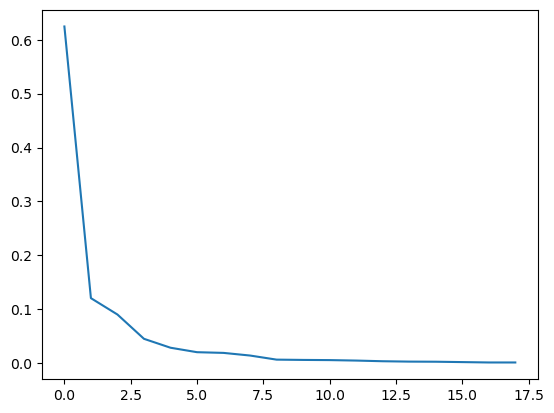

In [39]:
U , s, Vh = np.linalg.svd(Fi_w)
plt.plot(s**2/np.sum(s**2)) 

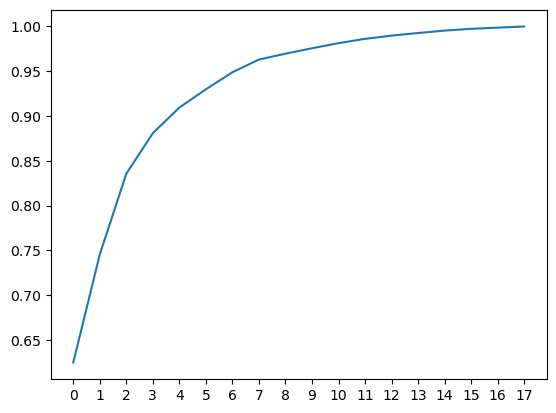

In [40]:
cum_var = np.cumsum (s**2/np.sum(s**2))
plt.plot(cum_var) 
plt.xticks(np.arange(18));

In [41]:
d = 8
Fi_w_comp = U[:,:d] @ np.diag(s[:d]) @ Vh[:d]

In [42]:
Vh.shape

(18, 18)

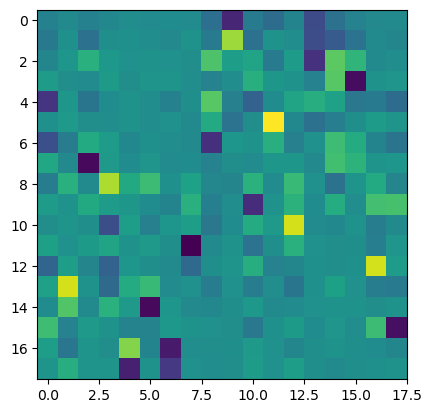

In [43]:
plt.imshow(Vh)

In [44]:
from maxvol import maxvol
d = 17
ranked_features, B = maxvol(Vh[:, :d], e = 1.05, k =100)
ranked_features

array([ 4, 13,  7,  8, 17, 14, 16, 11,  6,  0,  9,  5, 10,  1,  2,  3, 12])

In [45]:
from scipy.sparse.linalg import svds, LinearOperator
from scipy.sparse import diags, eye
def build_item_hybrid_svd_model(config, data, data_description):
    source_matrix = generate_interactions_matrix(data, data_description)
    Fi = data_description['item_features']
    alpha = config['alpha']
    Z = cosine_similarity(Fi)
    np.fill_diagonal(cosine_similarity(Fi), 0)
    item_feature_similarity_matrix = (1 - alpha) * eye(data_description['n_items']) + alpha * Z
    Lsf = cholesky(item_feature_similarity_matrix)

    u, s, _ = svds(source_matrix.T.dot(Lsf), k=config['rank'], return_singular_vectors='u')
    singular_values = s[::-1]
    user_factors = np.ascontiguousarray(u[::-1, :].T)
    return user_factors, singular_values

In [49]:
data_description['item_features'] = Fi
# data_description['item_features'] = eye(data_description['n_items'])
config = dict(
    rank = 40,
    alpha = 0.8
)

In [50]:
user_factors, singular_values = build_item_hybrid_svd_model(config, training, data_description)

In [51]:
user_factors.shape

(40, 6035)

In [52]:
from evaluation import topn_recommendations, topidx, downvote_seen_items
def hsvd_svd_recs(user_factors, testset, testset_description, topn = 20):
    recs = {} 
    gp = testset.groupby(testset_description['items'])[
        testset_description['users'],testset_description['feedback']
        ].agg(list)
    for itemid, users, ratings in gp.itertuples(name=None):
        ratings = np.array(ratings)
        rated_users = ratings.dot(user_factors[:,users].T)
        scores = rated_users.dot(user_factors)
        scores[users] = scores.min() - 1
        # print(scores.shape)
        idx = topidx(scores, topn)
        recs[itemid] = list(testset_description['user_index'][idx])
    return recs
    

In [53]:
topn = 20

In [54]:
recs = hsvd_svd_recs(user_factors, testset, data_description, topn)

/tmp/ipykernel_342925/4288276543.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gp = testset.groupby(testset_description['items'])[


In [55]:
def model_evaluate(recommended_users, holdout, holdout_description, topn=10):
    userid = holdout_description['users']
    holdout_users = holdout[userid].values
    assert recommended_users.shape[0] == len(holdout_users)
    hits_mask = recommended_users[:, :topn] == holdout_users.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_users.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_users = holdout_description['n_users']
    cov = np.unique(recommended_users).size / n_users
    return hr, mrr, cov

In [56]:
recommended_users = np.array(list(recs.values()))
holdout_description = data_description.copy()
model_evaluate(recommended_users, holdout, holdout_description, topn)

(0.017804154302670624, 0.0021874638714401325, 0.12029826014913007)

In [57]:
random_recs = np.random.choice(data_description['user_index'], recommended_users.shape)

In [58]:
model_evaluate(random_recs, holdout, holdout_description, topn)

(0.005934718100890208, 0.003195617438940881, 0.6687655343827672)

In [59]:
recommended_users.shape


(337, 20)

In [60]:
recommended_users

array([[1631, 2563, 3553, ..., 2601, 4054, 3413],
       [5148, 2563, 4054, ..., 1951, 1527, 3730],
       [5306, 2445, 5146, ..., 2497, 2596, 3019],
       ...,
       [4357,  195, 5845, ..., 3345, 2353, 4343],
       [4296, 1548, 5889, ..., 4720,  376, 4007],
       [2744, 1022, 4296, ..., 3345, 4764, 1032]])

In [61]:
Fi.shape

(3368, 18)

In [99]:
holdout_.userid.value_counts()

NameError: name 'holdout_' is not defined

In [66]:
import warnings
warnings.filterwarnings('ignore')
best_scores = {}
for n_f in range(1,17):
    best_hr = 0
    best_hp = None
    for rank in [ 30]:
        for alpha in np.linspace(0.1, 0.9, 5):
            try:
                data_description['item_features'] = Fi[:, ranked_features[:n_f]]
                config = dict(
                    rank = rank,
                    alpha = alpha
                )
                user_factors, singular_values = build_item_hybrid_svd_model(config, training, data_description)
                recs = hsvd_svd_recs(user_factors, testset, data_description, topn)
                recommended_users = np.array(list(recs.values()))
                hr, mrr, cov = model_evaluate(recommended_users, holdout, holdout_description, topn)
                print(n_f, rank, alpha, hr, mrr, cov, sep='\t')
                if hr > best_hr:
                    best_hr = hr
                    best_hp = (rank, alpha)
            except Exception as e:
                print(e.__str__)
    best_scores[n_f] = (best_hr, best_hp)
        

1	30	0.1	0.01483679525222552	0.00197334811578135	0.11483015741507871
1	30	0.30000000000000004	0.017804154302670624	0.0018701842754906117	0.1131731565865783
1	30	0.5	0.020771513353115726	0.0023295489541780338	0.11300745650372825
1	30	0.7000000000000001	0.020771513353115726	0.002734316458352067	0.11449875724937862
1	30	0.9	0.017804154302670624	0.002621862970527659	0.11516155758077878
2	30	0.1	0.01483679525222552	0.0018339927464556545	0.11449875724937862
2	30	0.30000000000000004	0.020771513353115726	0.002814281004191983	0.11549295774647887
2	30	0.5	0.020771513353115726	0.002843719090009891	0.11532725766362883
2	30	0.7000000000000001	0.020771513353115726	0.0027147061642610604	0.11582435791217896
2	30	0.9	0.017804154302670624	0.002340123172729212	0.11648715824357912
3	30	0.1	0.008902077151335312	0.0012734915924826906	0.11052195526097763
3	30	0.30000000000000004	0.017804154302670624	0.00305549215044764	0.11267605633802817
3	30	0.5	0.020771513353115726	0.0034528085793117808	0.1111847555923778

In [67]:
best_scores

{1: (0.020771513353115726, (30, 0.5)),
 2: (0.020771513353115726, (30, 0.30000000000000004)),
 3: (0.020771513353115726, (30, 0.5)),
 4: (0.020771513353115726, (30, 0.7000000000000001)),
 5: (0.020771513353115726, (30, 0.30000000000000004)),
 6: (0.017804154302670624, (30, 0.7000000000000001)),
 7: (0.01483679525222552, (30, 0.7000000000000001)),
 8: (0.011869436201780416, (30, 0.9)),
 9: (0.011869436201780416, (30, 0.9)),
 10: (0.011869436201780416, (30, 0.7000000000000001)),
 11: (0.011869436201780416, (30, 0.5)),
 12: (0.008902077151335312, (30, 0.30000000000000004)),
 13: (0.005934718100890208, (30, 0.1)),
 14: (0.005934718100890208, (30, 0.9)),
 15: (0.005934718100890208, (30, 0.7000000000000001)),
 16: (0.005934718100890208, (30, 0.9))}

In [68]:
hrs = [i[0] for i in best_scores.values()]

Text(0, 0.5, 'HR@20')

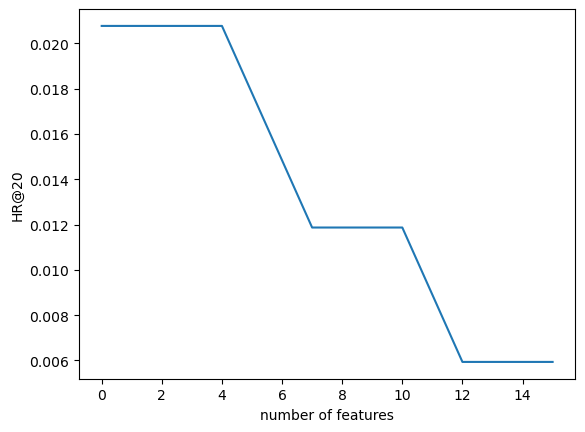

In [70]:
plt.plot(hrs)
plt.xlabel('number of features')
plt.ylabel('HR@20')